In [1]:
import importlib
import math

import Environment
import Models
from Environment.custom_env_gru import CustomEnvironment
import json
import torch
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from Models.ActorCritic import ActorCritic
from Models.SoftActorCritic import SoftActorCritic
from Models.DDQN_GRU import DoubleDQN

pygame 2.5.2 (SDL 2.28.3, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# importlib.reload(Environment)
# importlib.reload(Models)

In [3]:
torch.cuda.is_available()

True

In [4]:
f = open('Environment/env_config.json')
env_variables = json.load(f)
f.close

<function TextIOWrapper.close()>

In [5]:
env = CustomEnvironment(env_config=env_variables, render_mode="n")
# env = parallel_env(render_mode="human")
# env.reset(seed=42)

In [6]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler(feature_range=(0, 128))

In [7]:
ac_config = open('Environment/ac_config.json')
ac_variables = json.load(ac_config)
ac_config.close

sac_config = open('Environment/sac_config.json')
sac_variables = json.load(sac_config)
sac_config.close

ddqn_config = open('Environment/ddqn_config_gru.json')
ddqn_variables = json.load(ddqn_config)
ddqn_config.close

<function TextIOWrapper.close()>

In [8]:
ddqn_1 = DoubleDQN(ddqn_variables)
# ddqn_2 = DoubleDQN(ddqn_variables)
# ddqn_3 = DoubleDQN(ddqn_variables)
# ac = ActorCritic(ac_variables)
# sac = SoftActorCritic(sac_variables)

In [9]:
# models = {i:ddqn_1 for i in range(env.n_agents)}
models = {0: ddqn_1}

In [10]:
# dct = torch.load('brain_child.pkl')

In [11]:
# models[0].policy_net.load_state_dict(dct['policy_net'])
# models[0].target_net.load_state_dict(dct['target_net'])

In [12]:
# ddqn_1.policy_net.device

In [13]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for i, p in enumerate(named_parameters):
        
        if(p.requires_grad):
            layers.append(i)
            ave_grads.append(p.grad.cpu().abs().mean())
            max_grads.append(p.grad.cpu().abs().max())

    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    plt.show()

In [14]:
episodes = 100
episodes_returns = {}
# for agent in env.agents_objects():
#     episodes_returns[agent] = []
episodes_returns[0] = []

episodes_losses = {}
episodes_losses[0] = []
for episode in tqdm(range(episodes)): #episodes loop"

    if (episode + 1) % 20 == 0 and env.render_mode == 'greedy_inference':
        print("Greedy Inference starting")
        curr_obs,infos = env.reset() #reset environment after each episode\n",
        env.greedy_inference = True
    else:
        curr_obs,infos = env.reset() #reset environment after each episode\n",
    # print(curr_obs[0][1])
    losses = []
    while(env.agents): #until there are any surviving agents 

        actions = {}
        log_probs = {}

        for a in env.agents:
            # print(curr_obs[a])
            if env.greedy_inference:
                act, log_prob = models[a].select_greedy_action(state = curr_obs[a])
            else:
                act, log_prob = models[a].select_action(state = curr_obs[a])
            actions[a] = act
            log_probs[a] = log_prob

        # for i in range(env.n_agents): #objects contains all of the models, get the corresponding actions from each policy\n",
            
        #     if i in env.agents:
        #         act, log_prob = env.agents_objects[i].brain1.select_action(state = torch.tensor(curr_obs[i], dtype = torch.float32))
        #         actions[i] = act
        #         log_probs[i] = log_prob
        #     else:
        #         actions[i] = env.num_actions
        #         log_probs[i] = 69
            
        # print(actions)

        next_obs, rewards, terminations, truncations, infos = env.step(actions)
        # if env.timestep % 100 == 0:
        #     # plot_grad_flow(models[0].policy_net.parameters())
        #     print(rewards)
        
        if not env.greedy_inference:
            for id, obs in next_obs.items():
                # print("main shape", obs[0].shape)
                if obs is None:
                    print(env.timestep)
                    print("next state is None")
                models[id].push_to_buffer(curr_obs[id], actions[id], rewards[id], obs, log_probs[id], terminations[id])
                loss = models[id].update_weights()
                # print(loss)

                # if(terminations[id] == True):
                #     # loss = models[id].update_weights()
                #     print(f"Agent {id} died at timestep {env.timestep: 3d}. Current reward {rewards[id]: .3f}.")
                if loss is not None:
                    losses.append(loss)


        if env.timestep % 100 == 0:
            for id, agent in env.agents_objects.items():
                # plot_grad_flow(models[0].policy_net.parameters())
                print(f"{id}: {agent.reward: .3f}", end=' ')

            print()
        
        # for i in range(env.n_agents):

        #     if i in env.agents:
        #         env.agents_objects[i].brain1.push_to_buffer(torch.tensor(curr_obs[i], dtype = torch.float32),actions[i],rewards[i],torch.tensor(next_obs[i], dtype = torch.float32),log_probs[i],terminations[i])
        #         env.agents_objects[i].brain1.update_weights() 
            
        #     if i in env.justdie:
        #         env.justdie[i].brain1.push_to_buffer(torch.tensor(curr_obs[i], dtype = torch.float32),actions[i],rewards[i],torch.tensor(next_obs[i], dtype = torch.float32),log_probs[i],terminations[i])
        #         loss = env.justdie[i].brain1.update_weights() 
        #         del env.justdie[i]
        #         losses[i] = loss
        
        curr_obs = next_obs

        if env.timestep == env.max_episode_size - 1:
            for agent in env.agents_objects:
                episodes_returns[agent].append(env.agents_objects[agent].reward)
                episodes_losses[agent].append(np.array(losses).mean())
    
    print(f"Episode {episode} end")
    print(len(ddqn_1.replay_buffer))
    # print(f"Losses {losses}")
    # print(episodes_returns)
    # print(episodes_losses)
    print()




    if (episode + 1) % 10 == 0:
        # ddqn
        ddqn_dict = {}
        ddqn_dict['policy_net'] = models[0].policy_net.to('cpu').state_dict()
        ddqn_dict['target_net'] = models[0].target_net.to('cpu').state_dict()
        # torch.save(models[0].policy_net.state_dict())
        # torch.save(models[0].target_net.state_dict())
        torch.save(ddqn_dict, "SavedWeights/DDQN_GRU_Weights.pkl")
        del ddqn_dict
        models[0].policy_net.to(models[0].device)
        models[0].target_net.to(models[0].device)

        # # ac
        # ac_dict = {}
        # ac_dict['actor'] = models[1].actor.to('cpu').state_dict()
        # ac_dict['critic'] = models[1].critic.to('cpu').state_dict()
        # torch.save(ac_dict, "SavedWeights/AC_Weights.pkl")
        # del ac_dict
        # models[1].actor.to(models[1].device)
        # models[1].critic.to(models[1].device)
        # # torch.save(models[1].actor.state_dict())
        # # torch.save(models[1].critic.state_dict())

        # # sac
        # sac_dict = {}
        # sac_dict['actor_policy_net'] = models[2].actor_policy_net.to('cpu').state_dict()
        # sac_dict['critic_q_net'] = models[2].critic_q_net.to('cpu').state_dict()
        # sac_dict['critic_q_target_net'] = models[2].critic_q_target_net.to('cpu').state_dict()
        # sac_dict['log_alpha'] = models[2].log_alpha.to('cpu')
        # torch.save(sac_dict, "SavedWeights/SAC_Weights.pkl")
        # del sac_dict
        # models[2].actor_policy_net.to(models[2].device)
        # models[2].critic_q_net.to(models[2].device)
        # models[2].critic_q_target_net.to(models[2].device)
        # models[2].log_alpha.to(models[2].device)
        # torch.save(models[1].actor_policy_net.state_dict())
        # torch.save(models[1].critic_q_net.state_dict())
        # torch.save(models[1].critic_q_target_net.state_dict())

    env.close()

  0%|          | 0/100 [00:00<?, ?it/s]

0:  38.275 
0: -1.095 
0:  9.688 
0: -1.946 
Episode 0 end
491

0:  2.161 
0:  1.205 
0: -0.334 
0: -0.012 
Episode 1 end
982

0:  4.134 
0: -1.830 
0:  17.591 
0: -2.209 
Episode 2 end
1473

0:  14.718 
0:  37.399 
0:  14.755 
0:  4.143 
Episode 3 end
1964

0:  44.769 
0:  0.041 
0:  10.612 
0: -1.374 
Episode 4 end
2455

0:  3.288 
0: -1.733 
0:  1.747 
0:  2.364 
Episode 5 end
2946

0:  13.375 
0: -4.952 
0: -3.029 
0: -2.023 
Episode 6 end
3437

0:  24.087 
0:  10.964 
0: -1.833 
0:  26.306 
Episode 7 end
3928

0:  9.005 
0:  3.312 
0:  9.745 
0:  3.077 
Episode 8 end
4419

0:  7.404 
0:  11.608 
0:  6.496 
0: -2.608 
Episode 9 end
4910

0:  30.217 
0:  52.736 
0:  6.989 
0:  21.503 
Episode 10 end
5401

0: -2.681 
0:  9.247 
0: -4.856 
0: -5.597 
Episode 11 end
5892

0: -0.970 
0: -3.326 
0: -2.744 
0: -3.279 
Episode 12 end
6383

0:  16.283 
0:  5.369 
0:  0.674 
0:  18.571 
Episode 13 end
6874

0:  11.144 
0: -0.560 
0: -2.142 
0: -1.827 
Episode 14 end
7365

0:  0.614 
0:  14.8

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [17]:
def eps_thresh():
    # print(np.arange(0, 100*490, 490))
    arr = np.stack([np.arange(0, 100*490, 490), 40000 * np.ones(np.arange(0, 100*490, 490).shape[0])])
    arr = np.min(arr, axis=0)
    return 0.05 + (0.95 - 0.05) * np.exp(-1 * arr/40000)

eps_thresh().shape

(100,)

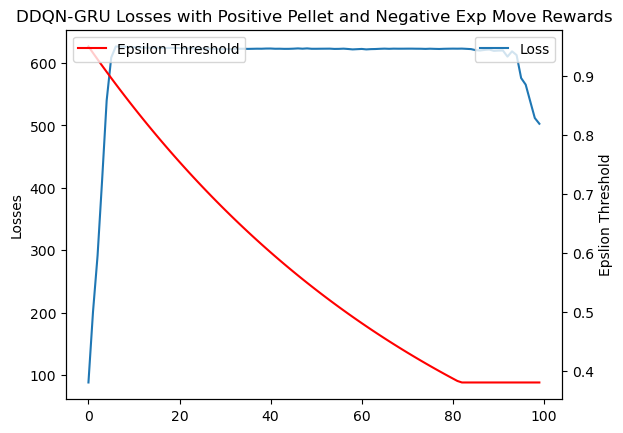

In [18]:
fig, ax = plt.subplots()
sns.lineplot(x=np.arange(episodes), y=episodes_losses[0], ax=ax, label='Loss')
plt.legend(loc='upper right')
plt.ylabel("Losses")
# sns.regplot(x='round', y='money', data=firm, ax=ax)
ax2 = ax.twinx()
sns.lineplot(x=np.arange(episodes), y=eps_thresh(), ax=ax2, color='r', label='Epsilon Threshold')
# sb.regplot(x='round', y='dead', data=firm, ax=ax2, color='r')
plt.legend(loc='upper left')
plt.xlabel("Episodes")
plt.ylabel("Epslion Threshold")
plt.title("DDQN-GRU Losses with Positive Pellet and Negative Exp Move Rewards")
plt.show()

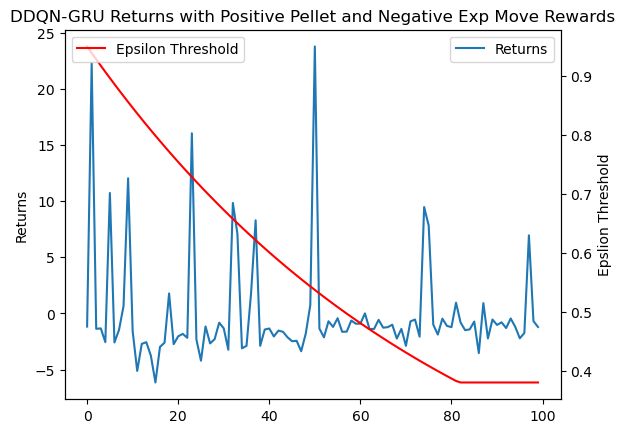

In [20]:
# sns.lineplot(x=np.arange(episodes), y=episodes_returns[0])
# # plt.xkcd(scale=0)
# # mpl.rcParams.update(mpl.rcParamsDefault)
# # plt.rcdefaults()
# plt.figure(figsize=(50, 100))
# plt.show()
# # plt.savefig(fname='DDQN-GRU-PosPellet.png')

fig, ax = plt.subplots()
sns.lineplot(x=np.arange(episodes), y=episodes_returns[0], ax=ax, label='Returns')
plt.legend(loc='upper right')
plt.ylabel("Returns")
# sns.regplot(x='round', y='money', data=firm, ax=ax)
ax2 = ax.twinx()
sns.lineplot(x=np.arange(episodes), y=eps_thresh(), ax=ax2, color='r', label='Epsilon Threshold')
# sb.regplot(x='round', y='dead', data=firm, ax=ax2, color='r')
plt.legend(loc='upper left')
plt.xlabel("Episodes")
plt.ylabel("Epslion Threshold")
plt.title("DDQN-GRU Returns with Positive Pellet and Negative Exp Move Rewards")
plt.show()

In [37]:
batch = models[0].replay_buffer.sample(16)

In [42]:
batch['next_states'][0][4]

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2.],
         [0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2.],
         [0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2.],
         [0., 0., 0., 0., 0., 0., 1., 0., 2., 2., 2., 2., 2.],
         [0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2.],
         [0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2.],
         [0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2.],
         [0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2.],
         [0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2.],
         [0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2.],
         [0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2.],
         [0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2.],
         [0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2.]]])

In [43]:
batch['actions']

tensor([[1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [3],
        [1],
        [1]])

In [24]:
batch['states'][0][2]

tensor([[[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
         [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 2., 2.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2.]]])

In [25]:
models[0].target_net((batch['next_states'][0][1].unsqueeze(0), batch['next_states'][1][1].unsqueeze(0)))

(tensor([[ 8.3681,  9.3746, 11.8540, 10.9066]], device='cuda:0',
        grad_fn=<ReluBackward0>),
 tensor([[-0.9958, -0.2410, -0.7557,  0.6965, -0.6180, -0.5998, -0.5205,  0.9886,
          -0.9315,  0.9170,  0.9882, -0.9566,  0.8443, -0.9243,  0.9718,  0.4707,
          -0.8885, -0.5003,  0.9143,  0.0321,  0.5680,  0.9761,  0.9679,  0.6568,
          -0.9937,  0.9283, -0.9946, -0.9929, -0.1870, -0.9821,  0.9999, -0.9975,
           0.0257, -0.9539, -0.4015,  0.8157, -0.9619,  0.9921,  0.9962,  0.9998,
           0.3326, -0.9998,  0.3299, -0.3925, -0.6503,  0.9634,  0.9972,  0.3140,
           0.9935, -0.8688, -0.9375,  0.9188, -0.7047, -0.9746,  0.9989, -0.9658,
          -0.9999, -0.9968,  0.9642,  0.6976, -0.9458,  0.9964,  0.4700, -0.9999]],
        device='cuda:0', grad_fn=<SqueezeBackward1>))

In [26]:
models[0].policy_net(batch['next_states'])[0]

tensor([[29.8710, 23.3287, 12.6259, 15.3339],
        [14.5291, 15.4611, 19.4664, 16.8968],
        [16.5154, 18.0821, 19.5855, 17.0065],
        [ 8.5972, 10.5278,  7.2429,  5.4294],
        [19.4912, 23.4622, 24.7663, 21.8706],
        [41.5883, 55.2755, 43.5050, 20.6963],
        [ 2.8092,  3.9818,  4.8468,  4.4396],
        [11.9132,  8.0811, 12.2809, 16.8148],
        [ 4.4331,  7.0303, 10.8734,  7.6409],
        [ 7.4936,  7.2023, 14.0561, 13.6339],
        [25.5488, 14.0510,  8.1580, 19.9140],
        [12.3408, 12.9958, 11.2058, 11.9050],
        [17.2721, 22.0187, 26.9541, 18.2521],
        [ 7.3571,  5.5342,  1.2591,  5.7130],
        [ 9.6712,  9.3952, 19.9726, 20.7264],
        [27.2702, 25.7994, 24.4575, 23.9895]], device='cuda:0',
       grad_fn=<ReluBackward0>)

In [27]:
models[0].policy_net(batch['next_states'])[0][np.arange(16), batch['actions'].squeeze()]

tensor([29.8710, 14.5291, 16.5154,  8.5972, 21.8706, 43.5050,  2.8092,  8.0811,
         4.4331,  7.4936, 14.0510, 12.3408, 17.2721,  1.2591,  9.3952, 27.2702],
       device='cuda:0', grad_fn=<IndexBackward0>)

In [28]:
(batch['rewards'].to('cuda') + batch['non_final_mask'].reshape(-1, 1).to('cuda') * 0.99 * models[0].target_net(batch['next_states'])[0])

tensor([[16.5165, 15.9998, 17.4598, 15.5000],
        [11.2011,  9.3707, 13.5750, 17.7765],
        [14.0849, 16.4535, 18.5834, 14.4261],
        [ 3.6582,  5.9860,  5.6754,  2.4424],
        [21.2776, 21.6797, 21.6511, 20.5427],
        [27.7996, 31.9697, 23.6624, 11.7389],
        [ 0.4210,  1.4624,  1.2227,  0.1863],
        [ 3.9514,  2.2227,  5.0533, 10.1678],
        [ 1.1388,  3.1407,  4.3566,  2.5232],
        [ 2.4032,  2.0829,  4.4697,  6.9454],
        [ 7.7404,  3.4814,  8.0871, 16.8489],
        [ 9.4502, 11.3908, 13.4467, 10.8927],
        [12.6487, 12.1068, 19.9850, 21.9029],
        [ 2.4777,  2.8650,  1.2755,  1.6276],
        [ 3.5495,  1.6313,  9.8021, 15.4830],
        [24.5879, 24.0525, 25.5202, 23.9706]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [29]:
models[0].calc_target_q_value(batch['rewards'].unsqueeze(0).to('cuda'), (batch['next_states'][0][0].unsqueeze(0), batch['next_states'][1][0].unsqueeze(0)), batch['non_final_mask'][0].unsqueeze(0).to('cuda'), models[0].target_net).shape

torch.Size([1, 16, 4])

In [30]:
models[0].calc_policy_loss((batch['states'][0][0].unsqueeze(0), batch['states'][1][0].unsqueeze(0)), batch['actions'][0].unsqueeze(0).to('cuda'), batch['rewards'].unsqueeze(0).to('cuda'), (batch['next_states'][0][0].unsqueeze(0), batch['next_states'][1][0].unsqueeze(0)), batch['non_final_mask'][0].unsqueeze(0).to('cuda'), models[0].policy_net, models[0].target_net)

d:\RL_Project\Evolution-Simulation\Models\DDQN_GRU.py:208: UserWarning: Using a target size (torch.Size([1, 16])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(curr_q[np.arange(curr_q.shape[0]), action.squeeze()], target_q.max(dim=-1)[0])


tensor(245.7482, device='cuda:0', grad_fn=<MseLossBackward0>)

C:\Users\srini\AppData\Local\Temp\ipykernel_30528\1553895725.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.imshow(curr_obs[0][0][1].astype(np.int), cmap='gray')


TypeError: Invalid shape (13,) for image data

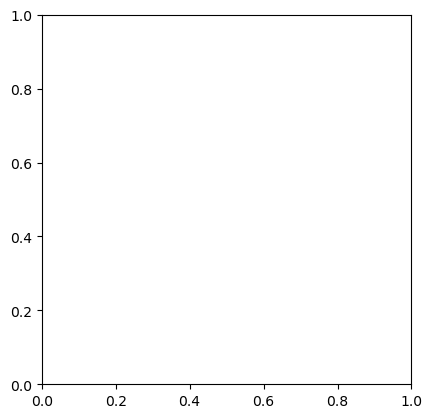

In [31]:
plt.imshow(curr_obs[0][0][1].astype(np.int), cmap='gray')

In [ ]:
plt.imshow(curr_obs[0][0][0].astype(np.int), cmap='gray')

In [ ]:
models[0].policy_net((torch.tensor(curr_obs[0][0]), torch.tensor(curr_obs[0][1]), torch.tensor(curr_obs[0][2]), torch.tensor(curr_obs[0][3])))

In [ ]:
models[0].select_action(curr_obs[0])

In [ ]:
models[0].steps_done